# A Few More DNNs
John Ignacio R.M. 2020-05-21

In [1]:
import pandas as pd
from glob import glob
ada_parent_dir = "../"
import sys
sys.path.append(ada_parent_dir)
import ada
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import sgd, adam, adagrad, adadelta
from keras.models import model_from_json
from keras.regularizers import l2

from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, roc_auc_score,
precision_recall_curve, average_precision_score)

#abstract classes
from abc import ABC, abstractmethod

Welcome to JupyROOT 6.20/04
Using TensorFlow backend.


In [2]:
data_path = "../processed_data"
signal = "Xtohh2000"

In [3]:
##############
### Models ###
##############

class DeepNeuralNetworkModel(ABC):
    """Abstract mother of models"""

    @abstractmethod
    def fit(self, X_train, y_train, w_train, X_val, y_val, w_val, epochs):
        print("Implement!")
    
    @abstractmethod
    def plot_training(self, width = 10, height = 6):
        print("Implement!")

    @abstractmethod
    def save(self, directory, version):
        print("Implement!")
    
    @abstractmethod
    def load(self, directory, version):
        print("Implement!")
    
    @abstractmethod
    def evaluate(self, X_test, y_test, w_test):
        print("Implement!")


class KerasModelBeta(DeepNeuralNetworkModel):
    """First stable version of the mother class for keras models"""
    def __init__(self, n_input):
        self.model = None
        self.history = None
        self.title = ""
        self.model_name = ""
    
    def fit(self, X_train, y_train, w_train, X_val, y_val, w_val, epochs):
        if self.model is not None:
            self.history = pd.DataFrame(self.model.fit(
                X_train.values,
                y_train,
                sample_weight = w_train,
                epochs = epochs,
                verbose = 1,
                validation_data = (
                    X_val.values,
                    y_val,
                    w_val
                )
            ).history)
        else:
            print("Build your model first!")
    
    def plot_training(self, width = 10, height = 6):
        #data
        train_loss = self.history['loss']
        val_loss = self.history['val_loss']
        epochs = len(train_loss)
        #plot
        plt.figure(1, figsize=(width, height))
        plt.plot(range(epochs), train_loss)
        plt.plot(range(epochs), val_loss)
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.title("Training vs Validation Loss " + self.title)
        plt.grid(True)
        plt.legend(['Training', 'Validation'])
        plt.show()
    
    def summary(self):
        self.model.summary()
    
    def save(self, directory, version):
        if self.model is not None:
            print("modelo")
            #save model
            model_json = self.model.to_json()
            with open(f"{directory}/{self.model_name}_v{version}.json", "w") as json_file:
                json_file.write(model_json)
                print("modelo")
            #save weights
            self.model.save_weights(f"{directory}/{self.model_name}_v{version}.h5")
        if self.history is not None:
            print("historia")
            #save training data
            with open(f"{directory}/{self.model_name}_v{version}.csv", mode='w') as f:
                print("mas historia")
                self.history.to_csv(f)

    
    def load(self, directory, version):
        # load json and create model
        if self.model is None:
            json_file = open(f"{directory}/{self.model_name}_v{version}.json", 'r')
            loaded_model_json = json_file.read()
            json_file.close()
            self.model = model_from_json(loaded_model_json)
        #load weights
        self.model.load_weights(f"{directory}/{self.model_name}_v{version}.h5")
        #load train history
        self.history = pd.read_csv(f"{directory}/{self.model_name}_v{version}.csv")
    
    def evaluate(self, X_test, y_test, w_test):
        y_pred_prob = self.model.predict(X_test)
        #parameter
        y_pred = (y_pred_prob > 0.4)

        print("Classification Report")
        print(classification_report(y_test, y_pred, sample_weight = w_test))
        print("Confussion Matrix")
        print(confusion_matrix(y_test, y_pred, sample_weight = w_test))
    
    def evaluate_v2(self, X_test, y_test):
        y_pred_prob = self.model.predict(X_test)
        #parameter
        y_pred = (y_pred_prob > 0.4)

        print("Classification Report")
        print(classification_report(y_test, y_pred))
        print("Confussion Matrix")
        print(confusion_matrix(y_test, y_pred))

    def plot_roc(self, X_test, y_test):
        y_scores = self.model.predict(X_test).ravel()

        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = roc_auc_score(y_test, y_scores)

        plt.figure()
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label='{} (area = {:.3f})'.format(self.model_name, roc_auc))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.grid()
        plt.show()

        return fpr, tpr, roc_auc
    
    def plot_recall(self, X_test, y_test):
        y_scores = self.model.predict(X_test).ravel()
        precision, recall, _ = precision_recall_curve(y_test, y_scores)

        prec_rec_auc = average_precision_score(y_test, y_scores)

        plt.figure()
        plt.plot([0, 1], [1, 0], 'k--')
        plt.plot(recall, precision, label='{} (area = {:.3f})'.format(self.model_name, prec_rec_auc))
        plt.xlabel('Precision')
        plt.ylabel('Recall')
        plt.title('Precision-recall curve')
        plt.legend(loc='best')
        plt.grid()
        plt.show()

        return precision, recall, prec_rec_auc


## Keras Model Beta 1
Based on Keras Model Pro 3, the best so far

In [4]:
class KMB1(KerasModelBeta):

    def __init__(self, n_input):
        #model
        self.model = Sequential()
        #input
        self.model.add(Dense(128, input_dim = n_input, kernel_initializer='uniform',activation='softplus'))
        #hidden layers
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(256, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(512, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(256, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(128, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(1, kernel_initializer='he_uniform', activation='sigmoid'))
        #compile
        self.model.compile(optimizer=adagrad(lr=0.01), loss='binary_crossentropy')

        #title
        self.title = 'optimizer: adagrad , lr = 0.01, loss = binary crossentropy'

        #training
        self.history = None

        #name
        self.model_name = "KMB1"

Train on 9097 samples, validate on 3033 samples
Epoch 1/100
9097/9097 [==============================] - 5s 503us/step - loss: 0.0025 - val_loss: 0.0017
Epoch 2/100
9097/9097 [==============================] - 1s 131us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/100
9097/9097 [==============================] - 1s 121us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/100
9097/9097 [==============================] - 1s 114us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/100
9097/9097 [==============================] - 1s 116us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/100
9097/9097 [==============================] - 1s 120us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/100
9097/9097 [==============================] - 1s 117us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
9097/9097 [==============================] - 1s 115us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/100
9097/9097 [==============================] - 1s 133us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1

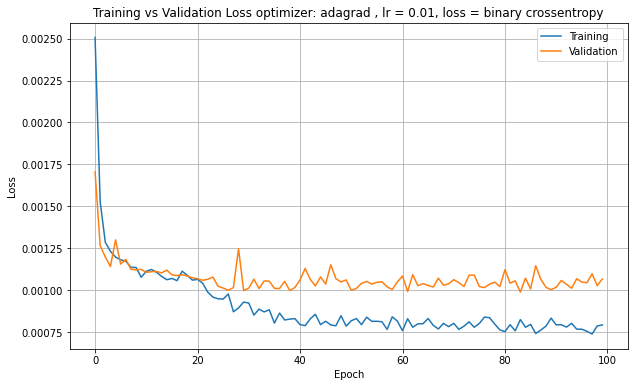

2020-05-22 11:10:40.473573: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-22 11:10:40.521374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-22 11:10:40.522704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 960M computeCapability: 5.0
coreClock: 1.176GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 74.65GiB/s
2020-05-22 11:10:40.522855: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-05-22 11:10:40.523014: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-05-22 11:10:40.786545: I tensorflow/stream_executor/platform/def

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test, w_train, w_val, w_test = ada.get_trainvaltest_from_dataset(data_path, signal, region = "SR", tag = 1, seed = 42)

model_1 = KMB1(X_train.shape[1])
model_1.fit(X_train, y_train, w_train, X_val, y_val, w_val, 100)
model_1.plot_training()

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.82      0.87 4.736367214691252
           1       0.76      0.89      0.82 3.088324681134691

    accuracy                           0.85 7.824691895825943
   macro avg       0.84      0.85      0.84 7.824691895825943
weighted avg       0.86      0.85      0.85 7.824691895825943

Confussion Matrix
[[3.86946465 0.86690256]
 [0.3336851  2.75463958]]
Classification Report
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       618
           1       0.94      0.90      0.92      2415

    accuracy                           0.87      3033
   macro avg       0.80      0.84      0.82      3033
weighted avg       0.89      0.87      0.88      3033

Confussion Matrix
[[ 487  131]
 [ 250 2165]]


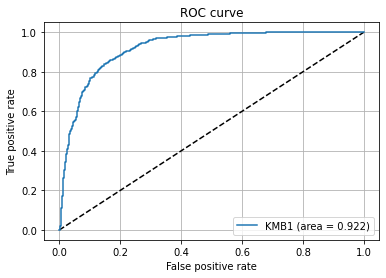

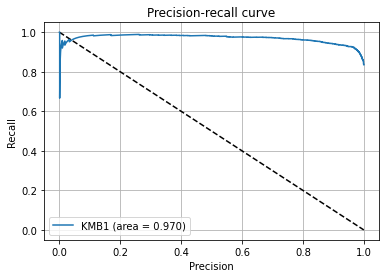

In [6]:
model_1.evaluate(X_test, y_test, w_test)
model_1.evaluate_v2(X_test, y_test)
fpr, tpr, roc_auc = model_1.plot_roc(X_test, y_test)
precision, recall, prec_rec_auc = model_1.plot_recall(X_test, y_test)

In [15]:
#model_1.save(data_path, "1")

modelo
modelo
historia
mas historia


## Keras Model Beta 2

In [7]:
class KMB2(KerasModelBeta):

    def __init__(self, n_input):
        #model
        self.model = Sequential()
        #input
        self.model.add(Dense(64, input_dim = n_input, kernel_initializer='uniform',activation='softplus'))
        #hidden layers
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(128, kernel_initializer='uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(256, kernel_initializer='uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(128, kernel_initializer='uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(64, kernel_initializer='uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
        #compile
        self.model.compile(optimizer=adagrad(lr=0.01), loss='binary_crossentropy')

        #title
        self.title = 'optimizer: adagrad , lr = 0.01, loss = binary crossentropy'

        #training
        self.history = None

        #name
        self.model_name = "KMB2"

- val_loss: 0.0011
Epoch 19/200
9097/9097 [==============================] - 1s 128us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 20/200
9097/9097 [==============================] - 1s 125us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 21/200
9097/9097 [==============================] - 1s 120us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 22/200
9097/9097 [==============================] - 1s 112us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 23/200
9097/9097 [==============================] - 1s 117us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 24/200
9097/9097 [==============================] - 1s 110us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 25/200
9097/9097 [==============================] - 1s 113us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 26/200
9097/9097 [==============================] - 1s 114us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 27/200
9097/9097 [==============================] - 1s 111us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 28/200
9097/9097 [===

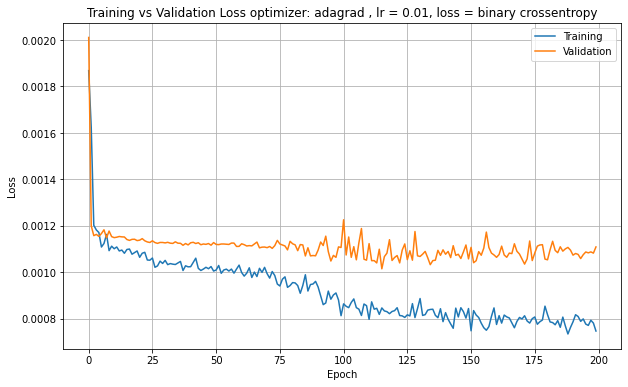

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test, w_train, w_val, w_test = ada.get_trainvaltest_from_dataset(data_path, signal, region = "SR", tag = 1, seed = 42)

model_2 = KMB2(X_train.shape[1])
model_2.fit(X_train, y_train, w_train, X_val, y_val, w_val, 200)
model_2.plot_training()

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.82      0.87 4.736367214691252
           1       0.76      0.89      0.82 3.088324681134691

    accuracy                           0.85 7.824691895825943
   macro avg       0.84      0.85      0.84 7.824691895825943
weighted avg       0.86      0.85      0.85 7.824691895825943

Confussion Matrix
[[3.8712341  0.86513312]
 [0.3420728  2.74625189]]
Classification Report
              precision    recall  f1-score   support

           0       0.65      0.79      0.72       618
           1       0.94      0.89      0.92      2415

    accuracy                           0.87      3033
   macro avg       0.80      0.84      0.82      3033
weighted avg       0.88      0.87      0.88      3033

Confussion Matrix
[[ 490  128]
 [ 259 2156]]


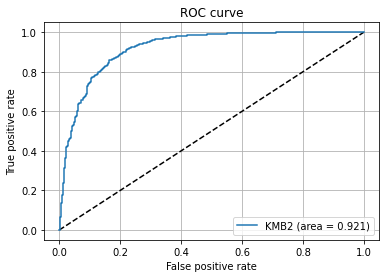

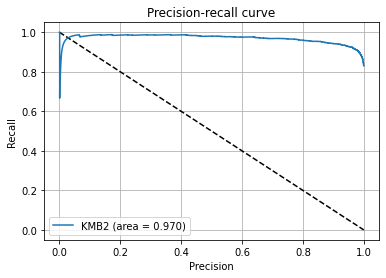

In [9]:
model_2.evaluate(X_test, y_test, w_test)
model_2.evaluate_v2(X_test, y_test)
fpr, tpr, roc_auc = model_2.plot_roc(X_test, y_test)
precision, recall, prec_rec_auc = model_2.plot_recall(X_test, y_test)

In [16]:
#model_2.save(data_path, "1")

modelo
modelo
historia
mas historia


## Keras Model Beta 3
More layers, More learning rate

In [10]:
class KMB3(KerasModelBeta):

    def __init__(self, n_input):
        #model
        self.model = Sequential()
        #input
        self.model.add(Dense(32, input_dim = n_input, kernel_initializer='uniform',activation='softplus'))
        #hidden layers
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(64, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(128, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(256, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(128, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(64, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(32, kernel_initializer='he_uniform', activation='softplus'))
        self.model.add(Dropout(rate=0.2))
        self.model.add(Dense(1, kernel_initializer='he_uniform', activation='sigmoid'))
        #compile
        self.model.compile(optimizer=adagrad(lr=0.05), loss='binary_crossentropy')

        #title
        self.title = 'optimizer: adagrad , lr = 0.05, loss = binary crossentropy'

        #training
        self.history = None

        #name
        self.model_name = "KMB3"

Train on 9097 samples, validate on 3033 samples
Epoch 1/50
9097/9097 [==============================] - 2s 213us/step - loss: 0.0045 - val_loss: 0.0020
Epoch 2/50
9097/9097 [==============================] - 1s 162us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 3/50
9097/9097 [==============================] - 1s 159us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 4/50
9097/9097 [==============================] - 1s 143us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/50
9097/9097 [==============================] - 1s 143us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/50
9097/9097 [==============================] - 1s 156us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/50
9097/9097 [==============================] - 1s 147us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/50
9097/9097 [==============================] - 1s 148us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/50
9097/9097 [==============================] - 1s 145us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/50
9097

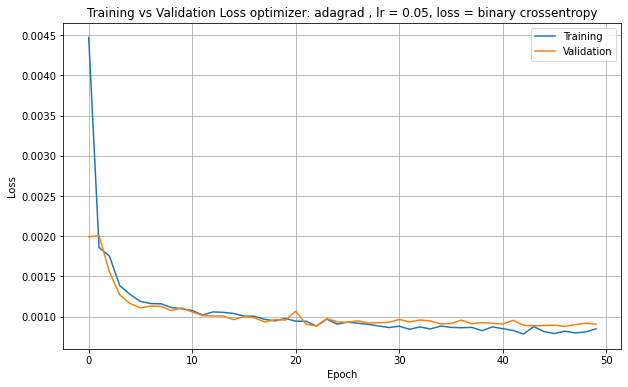

In [18]:
X_train, X_val, X_test, y_train, y_val, y_test, w_train, w_val, w_test = ada.get_trainvaltest_from_dataset(data_path, signal, region = "SR", tag = 1, seed = 420)

model_3 = KMB3(X_train.shape[1])
model_3.fit(X_train, y_train, w_train, X_val, y_val, w_val, 50)
model_3.plot_training()

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.78      0.85 4.911409097711487
           1       0.72      0.90      0.80 3.0623852007577277

    accuracy                           0.83 7.9737942984692145
   macro avg       0.82      0.84      0.82 7.9737942984692145
weighted avg       0.85      0.83      0.83 7.9737942984692145

Confussion Matrix
[[3.82558981 1.08581929]
 [0.3058396  2.7565456 ]]
Classification Report
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       640
           1       0.94      0.90      0.92      2393

    accuracy                           0.88      3033
   macro avg       0.81      0.85      0.83      3033
weighted avg       0.89      0.88      0.88      3033

Confussion Matrix
[[ 506  134]
 [ 239 2154]]


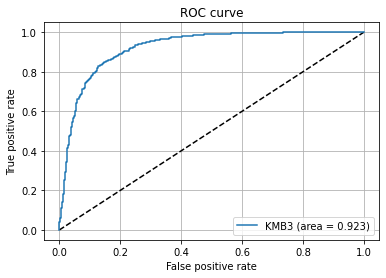

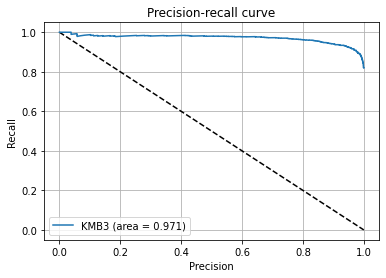

In [19]:
model_3.evaluate(X_test, y_test, w_test)
model_3.evaluate_v2(X_test, y_test)
fpr, tpr, roc_auc = model_3.plot_roc(X_test, y_test)
precision, recall, prec_rec_auc = model_3.plot_recall(X_test, y_test)

In [20]:
model_3.save(data_path, "1")

modelo
modelo
historia
mas historia
